 **Model Improvement to avoid overfitting**

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_dir = '/content/drive/My Drive/train'
test_dir = '/content/drive/My Drive/test1'

In [ ]:
img_size = (150, 150)
batch_size = 128

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # 20% validation data
)

# Train and validation generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',  # Multi-class classification
    shuffle=True,
    subset='training'  # Training subset
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',  # Multi-class classification
    shuffle=False,
    subset='validation'  # Validation subset
)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [ ]:
steps_per_epoch = np.ceil(train_generator.samples / batch_size).astype(int)
validation_steps = np.ceil(validation_generator.samples / batch_size).astype(int)

In [ ]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
base_model.trainable = False  # Freeze the base model layers

# Build the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),  # Dropout for regularization
    Dense(train_generator.num_classes, activation='softmax')  # Output layer
])

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(
    'best_mobilenetv2_model.keras', save_best_only=True, monitor='val_loss'
)



In [ ]:
Image = model.fit(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=10,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

Epoch 1/10
157/157 [==============================] - 3419s 20s/step - loss: 0.2450 - accuracy: 0.8994 - val_loss: 0.1657 - val_accuracy: 0.9256
Epoch 2/10
157/157 [==============================] - 230s 1s/step - loss: 0.1727 - accuracy: 0.9255 - val_loss: 0.1591 - val_accuracy: 0.9282
Epoch 3/10
157/157 [==============================] - 231s 1s/step - loss: 0.1625 - accuracy: 0.9316 - val_loss: 0.1526 - val_accuracy: 0.9320
Epoch 4/10
157/157 [==============================] - 230s 1s/step - loss: 0.1595 - accuracy: 0.9315 - val_loss: 0.1465 - val_accuracy: 0.9396
Epoch 5/10
157/157 [==============================] - 229s 1s/step - loss: 0.1586 - accuracy: 0.9331 - val_loss: 0.1525 - val_accuracy: 0.9350
Epoch 6/10
157/157 [==============================] - 231s 1s/step - loss: 0.1523 - accuracy: 0.9365 - val_loss: 0.1381 - val_accuracy: 0.9436
Epoch 7/10
157/157 [==============================] - 230s 1s/step - loss: 0.1464 - accuracy: 0.9359 - val_loss: 0.1410 - val_accuracy: 0.94

In [ ]:
model.evaluate(validation_generator)

40/40 [==============================] - 44s 1s/step - loss: 0.1422 - accuracy: 0.9398


[0.1422402411699295, 0.9398000240325928]

In [ ]:
model.save('final_mobilenetv2_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


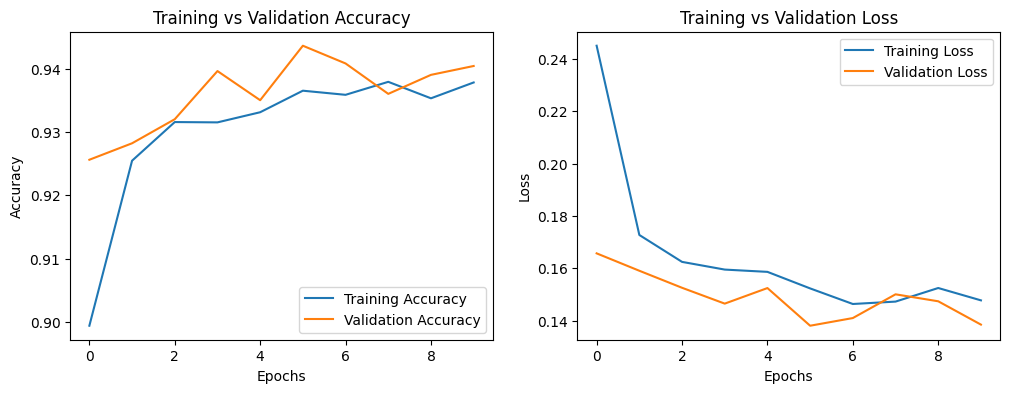

In [ ]:
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(Image.history['accuracy'], label='Training Accuracy')
plt.plot(Image.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(Image.history['loss'], label='Training Loss')
plt.plot(Image.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Select an image to verify the prediction:


Dropdown(description='Select Image:', options=('9099.jpg', '9097.jpg', '9106.jpg', '9117.jpg', '9101.jpg', '91…

1/1 [==============================] - 0s 40ms/step


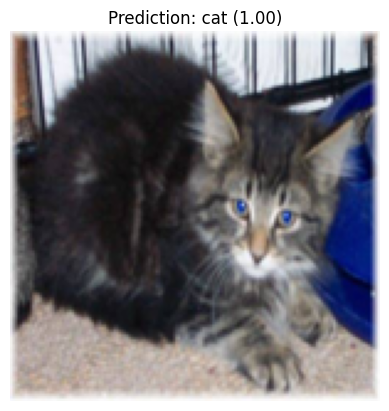

1/1 [==============================] - 0s 39ms/step


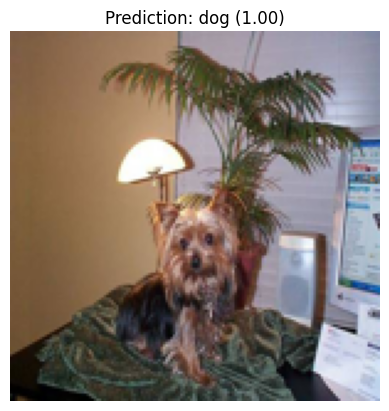

1/1 [==============================] - 0s 43ms/step


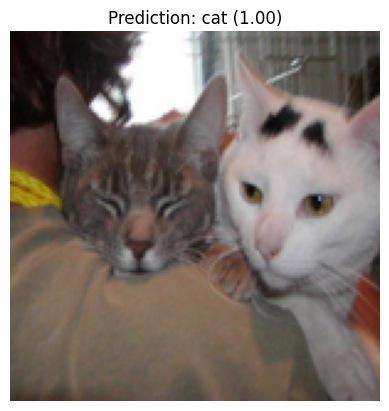

1/1 [==============================] - 0s 40ms/step


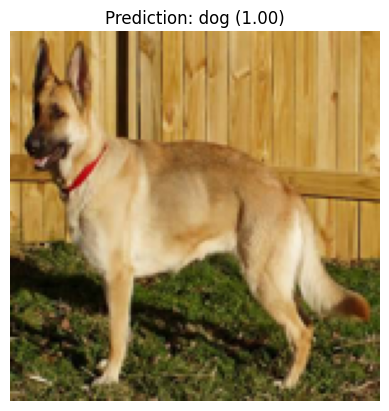

In [ ]:
import os
from IPython.display import display
import ipywidgets as widgets
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Define the test directory and load the trained model
test_dir = '/content/drive/My Drive/test1'
model = model  # Use the model you trained earlier

# Use training generator to get class indices (ensure it's defined earlier in your code)
class_indices = train_generator.class_indices  # Get the class indices from the training generator
class_labels = list(class_indices.keys())  # List of class names

# Get all image filenames in the test directory
image_files = [f for f in os.listdir(test_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Dropdown widget for selecting an image
dropdown = widgets.Dropdown(
    options=image_files,
    description='Select Image:',
    style={'description_width': 'initial'}
)

# Function to make predictions and display the selected image
def display_prediction(change):
    selected_image = change.new
    image_path = os.path.join(test_dir, selected_image)

    # Load and preprocess the image
    img = Image.open(image_path).resize((150, 150))  # Resize to match model input size
    img_array = np.array(img) / 255.0  # Normalize pixel values
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Make a prediction
    prediction = model.predict(img_array)

    if prediction.shape[1] == 1:  # Binary classification
        confidence = prediction[0][0]
        predicted_class = 'Dog' if confidence > 0.5 else 'Cat'
        confidence = confidence if predicted_class == 'Dog' else 1 - confidence
    else:  # Multi-class classification
        confidence = np.max(prediction)  # Confidence of the predicted class
        predicted_class_index = np.argmax(prediction)
        predicted_class = class_labels[predicted_class_index]  # Use training class labels

    # Display the image and prediction with confidence
    plt.imshow(img)
    plt.title(f"Prediction: {predicted_class} ({confidence:.2f})")
    plt.axis('off')
    plt.show()

# Attach the function to the dropdown
dropdown.observe(display_prediction, names='value')

# Display the dropdown
print("Select an image to verify the prediction:")
display(dropdown)


In [ ]:
!pip install pillow tkinterdnd2


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 492.7/492.7 kB 7.2 MB/s eta 0:00:00


In [ ]:
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 MB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.2/320.2 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.3/131.3 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 86.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.2/168.2 kB 9.5 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing

In [ ]:
import gradio as gr
import tensorflow as tf
from PIL import Image
import numpy as np

# Load the trained model
model = tf.keras.models.load_model('final_mobilenetv2_model.h5')  # Update with your model's path

# Preprocessing function
def preprocess_image(image):
    image = image.resize((150, 150))  # Resize to model input size
    img_array = np.array(image) / 255.0  # Normalize pixel values
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

# Prediction function
def predict(image):
    img_array = preprocess_image(image)
    prediction = model.predict(img_array)

    # For binary classification
    if prediction.shape[1] == 1:
        confidence = prediction[0][0]
        predicted_class = "Dog" if confidence > 0.5 else "Cat"
        confidence = confidence if predicted_class == "Dog" else 1 - confidence
    else:  # Multi-class classification
        confidence = np.max(prediction)
        predicted_class_index = np.argmax(prediction)
        predicted_class = "Dog" if predicted_class_index == 1 else "Cat"

    return f"Prediction: {predicted_class} (Confidence: {confidence:.2f})"

# Create Gradio Interface
interface = gr.Interface(
    fn=predict,  # Function to call
    inputs=gr.Image(type="pil"),  # Input type: Image
    outputs=gr.Textbox(),  # Output type: Textbox
    title="Cats vs Dogs Classifier",  # Title of the app
    description="Upload an image of a cat or dog, and the model will classify it for you."
)

# Launch the interface
interface.launch()


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://754a266b7a0edad4c6.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
